In [1]:
import gym
import random, math
import numpy as np
import arcade
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

        
from LightEnvCopy import LightEnv

import gym.spaces
from gym.spaces import Discrete, Box

from ray.rllib.env.env_context import EnvContext
from ray.rllib.models import ModelCatalog

from collections import namedtuple

# Do the math to figure out our screen dimensions
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 600
SCREEN_TITLE = "Game 1: Let There Be Light!"

# COnvenient data structure to hold information about actions
Action = namedtuple('Action', 'name index delta_i delta_j')

up = Action('up', 0, -1, 0)    
down = Action('down', 1, 1, 0)    
left = Action('left', 2, 0, -1)    
right = Action('right', 3, 0, 1)    

index_to_actions = {}
for action in [up, down, left, right]:
    index_to_actions[action.index] = action
# print(index_to_actions[0].name)
str_to_actions = {}
for action in [up, down, left, right]:
    str_to_actions[action.name] = action
#TF End - Adding in actions for action conversion


class LightEnvWrapper(gym.Env, LightEnv):
    """Class that wraps the Lights Environment to make it 
    compatible with RLLib."""

    metadata = {"render.modes": ["rgb_array", "state_pixels"]}
    
    def __init__(self, config: EnvContext):
        super().__init__(SCREEN_WIDTH, SCREEN_HEIGHT, SCREEN_TITLE)
        self.torch_collected = False
        self.torch_collected_count = []
        self.mygame = LightEnv
        self.steps_taken = 0
        #The action space is a choice of 4 actions: U/D/L/R.
        self.action_space = Discrete(4)
        
        #The observation space is a fixed image of the current game screen
        self.observation_space = Box(low=0, high=255, shape=(84,84, 4), dtype=np.uint8)
        
    def reset(self):
        print("resetting in wrapper")
        
        if self.torch_collected == 1:
            print("Torch was collected this episode!")
        else:
            print("Torch was not collected this episode...")
        self.torch_collected_count.append(self.torch_collected)
        print(self.torch_collected_count)

        self.render(self)
        #Resets the state of the environment for a new episode and an initial observation.
        obs_mygame = self.mygame.reset(self)
        
        #Open up the resetted image to verify working correctly.
        obs_mygame.show()
        
        self.mygame.on_draw(self)
        #Convert observation to 84x84 resolution and np array for rllib.
        obs = self.convert_observations(obs_mygame)
        
        self.steps_taken = 0
        return obs

    def step(self, action):
        self.steps_taken += 1
        
        #Making sure an action is chosen, either: 0, 1, 2, 3.
        assert action in [0, 1, 2, 3] #0-up,1-down,2-left,3-right.
        
        #Convert the numeric action to a keyword: up, down, left, right.
        actions_myenv = index_to_actions[action].name #returns a word, one of: up/down/left/right
#         print(f"action taken: {actions_myenv}")
        
        #Update the window with on_update()
        self.render(self)
#         print("env rendered")
        #Compute observation extracted from the window (800x600), with reward and done flag.
        obs, reward, done, torch_collected, fps_check = self.mygame.step(self,actions_myenv)
        if torch_collected == True:
            self.torch_collected = 1
        else:
            self.torch_collected = 0
                    
        if self.steps_taken % 100 == 0: #33 steps roughly equates to 1 second in game time
            print(f"total score is {self.score} at time: {self.mygame.time_taken_reported(self)}")
            print(f"FPS is currently: {fps_check}")
        #Convert observation to 84x84 resolution and np array for rllib.
        obs_mygame = self.convert_observations(obs)
        
        #If the reward has been obtained, reset the environment and start again
        if done == True:
            print(f"done is {done}, resetting environment in wrapper.")
            print(f"steps taken: {self.steps_taken}")
            obs.show()
            self.reset()
        
        return obs_mygame, reward, done, {}

    def seed(self, seed=None):
        random.seed(seed)

    def convert_observations(self, obs_mygame): #resizing and converting to array for rllib processing
        # We normalize and concatenate observations
        obs = obs_mygame
        obs_resized = obs.resize((84,84))
        obsarray = np.array(obs_resized)
        return obsarray
    
    def render(self, mode='state_pixels'):
#         self.mygame.update(self)
        self.mygame.on_draw(self)
        test = self.mygame.time_taken_reported(self)
        

C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\tensorflow_probability\python\__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


### Now run the rllib script to train the agent

In [2]:
import gym
import ray.rllib.agents.ppo.ppo as ppo
from ray.rllib.algorithms.ppo import PPOConfig
from ray import air
from ray import tune
config = PPOConfig()


from ray.rllib.algorithms.ppo import PPOConfig
RAY_DISABLE_MEMORY_MONITOR = 1
config = PPOConfig().training(gamma=0.99, lr=0.01, kl_coeff=0.2, entropy_coeff=1,
#                               entropy_coeff_schedule=[[0,1],[1000,0]],
                             sgd_minibatch_size=128, num_sgd_iter=60)\
            .resources(num_gpus=1)\
            .rollouts(num_envs_per_worker=1, num_rollout_workers=1, recreate_failed_workers=True, horizon=30000)
config.normalize_actions=False
config.env=LightEnvWrapper
config.clip_actions=False
print(config.to_dict())
# Build a Algorithm object from the config
trainer = ppo.PPOTrainer(config=config)

avg_rewards = []
num_iterations = []
for episode in range(100):
    print("Starting episode ", episode)
    # Perform one iteration of training the policy with PPO
    result = trainer.train()
    #print(pretty_print(result))
    print("episode reward mean: ", result['episode_reward_mean'])
    avg_rewards.append(result['episode_reward_mean'])
    num_iterations.append(episode)
    if episode % 10 == 0:
        checkpoint = trainer.save()
        print("checkpoint saved at", checkpoint)
    print("End of episode ", episode)



    

{'extra_python_environs_for_driver': {}, 'extra_python_environs_for_worker': {}, 'num_gpus': 0, 'num_cpus_per_worker': 1, 'num_gpus_per_worker': 0, '_fake_gpus': False, 'custom_resources_per_worker': {}, 'placement_strategy': 'PACK', 'eager_tracing': False, 'eager_max_retraces': 20, 'tf_session_args': {'intra_op_parallelism_threads': 2, 'inter_op_parallelism_threads': 2, 'gpu_options': {'allow_growth': True}, 'log_device_placement': False, 'device_count': {'CPU': 1}, 'allow_soft_placement': True}, 'local_tf_session_args': {'intra_op_parallelism_threads': 8, 'inter_op_parallelism_threads': 8}, 'env': <class '__main__.LightEnvWrapper'>, 'env_config': {}, 'observation_space': None, 'action_space': None, 'env_task_fn': None, 'render_env': False, 'clip_rewards': None, 'normalize_actions': False, 'clip_actions': False, 'disable_env_checking': False, 'num_workers': 1, 'num_envs_per_worker': 1, 'sample_collector': <class 'ray.rllib.evaluation.collectors.simple_list_collector.SimpleListCollecto

C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(
2022-09-27 00:21:42,084	INFO worker.py:1518 -- Started a local Ray instance.
(pid=33260) Windows fatal exception: code 0xc0000139
(pid=33260) 
(pid=33260) C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\tensorflow_probability\python\__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(pid=33260)   if (distutils.version.LooseVersion(tf.__version__) <
(RolloutWorker pid=33260) 2022-09-27 00:21:59,017	WARNING env.py:142 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you hav

(RolloutWorker pid=33260) resetting in wrapper
(RolloutWorker pid=33260) Torch was not collected this episode...
(RolloutWorker pid=33260) [False]
(RolloutWorker pid=33260) resetting


2022-09-27 00:22:04,681	INFO trainable.py:160 -- Trainable.setup took 26.231 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-09-27 00:22:04,684	WARNING util.py:65 -- Install gputil for GPU system monitoring.


Starting episode  0


2022-09-27 00:22:06,401	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.set_weights() (pid=33260, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002445D3FC070>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.36 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
33260	0.71GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray
17236	0.48GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
27808	0.38GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
8612	0.29GiB	C:\Progra

(RolloutWorker pid=33260) resetting in wrapper
(RolloutWorker pid=33260) Torch was not collected this episode...
(RolloutWorker pid=33260) [False, 0]
(RolloutWorker pid=33260) resetting
(RolloutWorker pid=33260) total score is -3 at time: 2
(RolloutWorker pid=33260) total score is -4 at time: 3
(RolloutWorker pid=33260) total score is -6 at time: 5
(RolloutWorker pid=33260) total score is -9 at time: 7
(RolloutWorker pid=33260) total score is -10 at time: 8
(RolloutWorker pid=33260) total score is -13 at time: 10
(RolloutWorker pid=33260) total score is -15 at time: 12
(RolloutWorker pid=33260) total score is -16 at time: 13
(RolloutWorker pid=33260) total score is -18 at time: 15
(RolloutWorker pid=33260) total score is -21 at time: 17
(RolloutWorker pid=33260) total score is -22 at time: 18
(RolloutWorker pid=33260) total score is -24 at time: 20
(RolloutWorker pid=33260) total score is -26 at time: 22
(RolloutWorker pid=33260) total score is -27 at time: 23
(RolloutWorker pid=33260)

2022-09-27 00:32:14,504	ERROR algorithm.py:2173 -- Error in training or evaluation attempt! Trying to recover.
Traceback (most recent call last):
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\algorithms\algorithm.py", line 2373, in _run_one_training_iteration
    results = self.training_step()
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\algorithms\ppo\ppo.py", line 407, in training_step
    train_batch = synchronous_parallel_sample(
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\execution\rollout_ops.py", line 100, in synchronous_parallel_sample
    sample_batches = ray.get(
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\worker.py", line 2275, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RayOutOfMemoryError): ray::

2022-09-27 00:32:16,014	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::RolloutWorker.sample_with_count() (pid=33260, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000002445D3FC070>)
  File "python\ray\_raylet.pyx", line 620, in ray._raylet.execute_task
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\memory_monitor.py", line 162, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node DESKTOP-BKAPO4O is used (7.52 / 7.73 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
23140	0.56GiB	C:\Program Files (x86)\Microsoft\Edge\Application\msedge.exe --type=gpu-process --gpu-preferences=UA
27808	0.44GiB	C:\Users\Tim\Anaconda3\envs\rllib\python.exe -m ipykernel_launcher -f C:\Users\Tim\AppData\Roaming\j
17236	0.4GiB	C:\Users\Tim\AppData\Local\Microsoft\OneDrive\OneDrive.exe /background
1016	0.38GiB	C:\P

(RolloutWorker pid=11956) resetting in wrapper
(RolloutWorker pid=11956) Torch was not collected this episode...
(RolloutWorker pid=11956) [False]
(RolloutWorker pid=11956) resetting
(RolloutWorker pid=11956) resetting in wrapper
(RolloutWorker pid=11956) Torch was not collected this episode...
(RolloutWorker pid=11956) [False, 0]
(RolloutWorker pid=11956) resetting
(RolloutWorker pid=11956) total score is -4 at time: 2
(RolloutWorker pid=11956) total score is -6 at time: 3
(RolloutWorker pid=11956) total score is -9 at time: 5
(RolloutWorker pid=11956) total score is -12 at time: 7
(RolloutWorker pid=11956) total score is -14 at time: 8
(RolloutWorker pid=11956) total score is -17 at time: 10
(RolloutWorker pid=11956) total score is -20 at time: 12
(RolloutWorker pid=11956) total score is -21 at time: 13
(RolloutWorker pid=11956) total score is -24 at time: 15
(RolloutWorker pid=11956) total score is -26 at time: 17
(RolloutWorker pid=11956) total score is -28 at time: 18
(RolloutWork

(RolloutWorker pid=11956) total score is -160 at time: 135
(RolloutWorker pid=11956) total score is -162 at time: 137
(RolloutWorker pid=11956) total score is -163 at time: 138
(RolloutWorker pid=11956) total score is -165 at time: 140
(RolloutWorker pid=11956) total score is -167 at time: 142
(RolloutWorker pid=11956) total score is -168 at time: 143
(RolloutWorker pid=11956) total score is -170 at time: 145
(RolloutWorker pid=11956) total score is -172 at time: 147
(RolloutWorker pid=11956) total score is -173 at time: 148
(RolloutWorker pid=11956) total score is -175 at time: 150
(RolloutWorker pid=11956) total score is -177 at time: 152
(RolloutWorker pid=11956) total score is -178 at time: 153
(RolloutWorker pid=11956) total score is -180 at time: 155
(RolloutWorker pid=11956) total score is -182 at time: 157
(RolloutWorker pid=11956) total score is -183 at time: 158
(RolloutWorker pid=11956) total score is -185 at time: 160
(RolloutWorker pid=11956) total score is -187 at time: 1

(RolloutWorker pid=11956) total score is -22 at time: 12
(RolloutWorker pid=11956) total score is -23 at time: 13
(RolloutWorker pid=11956) total score is -25 at time: 15
(RolloutWorker pid=11956) total score is -27 at time: 17
(RolloutWorker pid=11956) total score is -29 at time: 18
(RolloutWorker pid=11956) total score is -32 at time: 20
(RolloutWorker pid=11956) total score is -34 at time: 22
episode reward mean:  -22.666666666666668
End of episode  5
Starting episode  6
(RolloutWorker pid=11956) total score is -35 at time: 23
(RolloutWorker pid=11956) total score is -37 at time: 25
(RolloutWorker pid=11956) total score is -40 at time: 27
(RolloutWorker pid=11956) total score is -42 at time: 28
(RolloutWorker pid=11956) total score is -44 at time: 30
(RolloutWorker pid=11956) total score is -46 at time: 32
(RolloutWorker pid=11956) total score is -47 at time: 33
(RolloutWorker pid=11956) total score is -49 at time: 35
(RolloutWorker pid=11956) total score is -51 at time: 37
(Rollout

(RolloutWorker pid=11956) total score is -119 at time: 92
(RolloutWorker pid=11956) total score is -120 at time: 93
(RolloutWorker pid=11956) total score is -122 at time: 95
(RolloutWorker pid=11956) total score is -124 at time: 97
(RolloutWorker pid=11956) total score is -126 at time: 98
(RolloutWorker pid=11956) total score is -128 at time: 100
(RolloutWorker pid=11956) total score is -130 at time: 102
(RolloutWorker pid=11956) total score is -131 at time: 103
(RolloutWorker pid=11956) total score is -133 at time: 105
(RolloutWorker pid=11956) total score is -135 at time: 107
(RolloutWorker pid=11956) total score is -136 at time: 108
(RolloutWorker pid=11956) total score is -138 at time: 110
(RolloutWorker pid=11956) total score is -140 at time: 112
(RolloutWorker pid=11956) total score is -141 at time: 113
(RolloutWorker pid=11956) total score is -143 at time: 115
(RolloutWorker pid=11956) total score is -145 at time: 117
(RolloutWorker pid=11956) total score is -146 at time: 118
(R

(RolloutWorker pid=11956) total score is -88 at time: 77
(RolloutWorker pid=11956) total score is -89 at time: 78
(RolloutWorker pid=11956) total score is -91 at time: 80
(RolloutWorker pid=11956) total score is -93 at time: 82
(RolloutWorker pid=11956) total score is -94 at time: 83
(RolloutWorker pid=11956) total score is -97 at time: 85
(RolloutWorker pid=11956) total score is -99 at time: 87
(RolloutWorker pid=11956) total score is -100 at time: 88
(RolloutWorker pid=11956) total score is -102 at time: 90
(RolloutWorker pid=11956) total score is -104 at time: 92
(RolloutWorker pid=11956) total score is -106 at time: 93
(RolloutWorker pid=11956) total score is -108 at time: 95
episode reward mean:  -14.666666666666666
checkpoint saved at C:\Users\Tim/ray_results\PPO_LightEnvWrapper_2022-09-27_00-21-38h9g48nvt\checkpoint_000011
End of episode  10
Starting episode  11
(RolloutWorker pid=11956) total score is -110 at time: 97
(RolloutWorker pid=11956) total score is -111 at time: 98
(R

(RolloutWorker pid=11956) total score is -106 at time: 88
(RolloutWorker pid=11956) total score is -108 at time: 90
episode reward mean:  -5.75
End of episode  12
Starting episode  13
(RolloutWorker pid=11956) total score is -110 at time: 92
(RolloutWorker pid=11956) total score is -111 at time: 93
(RolloutWorker pid=11956) total score is -114 at time: 95
(RolloutWorker pid=11956) total score is -116 at time: 97
(RolloutWorker pid=11956) total score is -117 at time: 98
(RolloutWorker pid=11956) total score is -119 at time: 100
(RolloutWorker pid=11956) total score is -121 at time: 102
(RolloutWorker pid=11956) total score is -122 at time: 103
(RolloutWorker pid=11956) total score is -124 at time: 105
(RolloutWorker pid=11956) total score is -126 at time: 107
(RolloutWorker pid=11956) total score is -127 at time: 108
(RolloutWorker pid=11956) total score is -129 at time: 110
(RolloutWorker pid=11956) total score is -131 at time: 112
(RolloutWorker pid=11956) total score is -132 at time:

(RolloutWorker pid=11956) total score is -118 at time: 102
(RolloutWorker pid=11956) total score is -119 at time: 103
(RolloutWorker pid=11956) total score is -121 at time: 105
(RolloutWorker pid=11956) total score is -123 at time: 107
(RolloutWorker pid=11956) total score is -124 at time: 108
(RolloutWorker pid=11956) total score is -127 at time: 110
(RolloutWorker pid=11956) total score is -129 at time: 112
(RolloutWorker pid=11956) total score is -130 at time: 113
(RolloutWorker pid=11956) total score is -132 at time: 115
(RolloutWorker pid=11956) total score is -134 at time: 117
(RolloutWorker pid=11956) total score is -135 at time: 118
(RolloutWorker pid=11956) total score is -137 at time: 120
(RolloutWorker pid=11956) total score is -139 at time: 122
(RolloutWorker pid=11956) total score is -141 at time: 123
(RolloutWorker pid=11956) total score is -143 at time: 125
(RolloutWorker pid=11956) total score is -145 at time: 127
(RolloutWorker pid=11956) total score is -146 at time: 1

(RolloutWorker pid=11956) total score is -316 at time: 287
(RolloutWorker pid=11956) total score is -317 at time: 288
(RolloutWorker pid=11956) total score is -319 at time: 290
(RolloutWorker pid=11956) total score is -321 at time: 292
(RolloutWorker pid=11956) total score is -322 at time: 293
(RolloutWorker pid=11956) total score is -324 at time: 295
(RolloutWorker pid=11956) total score is -326 at time: 297
(RolloutWorker pid=11956) total score is -328 at time: 298
(RolloutWorker pid=11956) total score is -330 at time: 300
(RolloutWorker pid=11956) total score is -332 at time: 302
(RolloutWorker pid=11956) total score is -333 at time: 303
(RolloutWorker pid=11956) total score is -335 at time: 305
(RolloutWorker pid=11956) total score is -337 at time: 307
(RolloutWorker pid=11956) total score is -338 at time: 308
(RolloutWorker pid=11956) total score is -341 at time: 310
(RolloutWorker pid=11956) total score is -343 at time: 312
(RolloutWorker pid=11956) total score is -344 at time: 3

(RolloutWorker pid=11956) total score is -506 at time: 468
(RolloutWorker pid=11956) total score is -508 at time: 470
(RolloutWorker pid=11956) total score is -510 at time: 472
(RolloutWorker pid=11956) total score is -511 at time: 473
(RolloutWorker pid=11956) total score is -513 at time: 475
(RolloutWorker pid=11956) total score is -515 at time: 477
(RolloutWorker pid=11956) total score is -516 at time: 478
(RolloutWorker pid=11956) total score is -518 at time: 480
(RolloutWorker pid=11956) total score is -520 at time: 482
(RolloutWorker pid=11956) total score is -521 at time: 483
(RolloutWorker pid=11956) total score is -523 at time: 485
(RolloutWorker pid=11956) total score is -525 at time: 487
(RolloutWorker pid=11956) total score is -526 at time: 488
(RolloutWorker pid=11956) total score is -528 at time: 490
(RolloutWorker pid=11956) total score is -530 at time: 492
(RolloutWorker pid=11956) total score is -531 at time: 493
(RolloutWorker pid=11956) total score is -533 at time: 4

(RolloutWorker pid=11956) total score is -695 at time: 655
(RolloutWorker pid=11956) total score is -697 at time: 657
(RolloutWorker pid=11956) total score is -698 at time: 658
(RolloutWorker pid=11956) total score is -700 at time: 660
(RolloutWorker pid=11956) total score is -702 at time: 662
(RolloutWorker pid=11956) total score is -703 at time: 663
(RolloutWorker pid=11956) total score is -705 at time: 665
(RolloutWorker pid=11956) total score is -707 at time: 667
episode reward mean:  -13.666666666666666
End of episode  23
Starting episode  24
(RolloutWorker pid=11956) total score is -708 at time: 668
(RolloutWorker pid=11956) total score is -710 at time: 670
(RolloutWorker pid=11956) total score is -712 at time: 672
(RolloutWorker pid=11956) total score is -713 at time: 673
(RolloutWorker pid=11956) total score is -715 at time: 675
(RolloutWorker pid=11956) total score is -717 at time: 677
(RolloutWorker pid=11956) total score is -718 at time: 678
(RolloutWorker pid=11956) total s

(RolloutWorker pid=11956) total score is -882 at time: 840
(RolloutWorker pid=11956) total score is -884 at time: 842
(RolloutWorker pid=11956) total score is -885 at time: 843
(RolloutWorker pid=11956) total score is -887 at time: 845
(RolloutWorker pid=11956) total score is -889 at time: 847
(RolloutWorker pid=11956) total score is -890 at time: 848
(RolloutWorker pid=11956) total score is -892 at time: 850
(RolloutWorker pid=11956) total score is -894 at time: 852
(RolloutWorker pid=11956) total score is -895 at time: 853
(RolloutWorker pid=11956) total score is -897 at time: 855
(RolloutWorker pid=11956) total score is -899 at time: 857
(RolloutWorker pid=11956) total score is -900 at time: 858
(RolloutWorker pid=11956) total score is -902 at time: 860
(RolloutWorker pid=11956) total score is -904 at time: 862
(RolloutWorker pid=11956) total score is -905 at time: 863
(RolloutWorker pid=11956) total score is -907 at time: 865
(RolloutWorker pid=11956) total score is -909 at time: 8

(RolloutWorker pid=11956) total score is -1065 at time: 1023
(RolloutWorker pid=11956) total score is -1067 at time: 1025
(RolloutWorker pid=11956) total score is -1069 at time: 1027
(RolloutWorker pid=11956) total score is -1070 at time: 1028
(RolloutWorker pid=11956) total score is -1072 at time: 1030
(RolloutWorker pid=11956) total score is -1074 at time: 1032
(RolloutWorker pid=11956) total score is -1075 at time: 1033
(RolloutWorker pid=11956) total score is -1077 at time: 1035
(RolloutWorker pid=11956) total score is -1079 at time: 1037
(RolloutWorker pid=11956) total score is -1080 at time: 1038
(RolloutWorker pid=11956) total score is -1082 at time: 1040
(RolloutWorker pid=11956) total score is -1084 at time: 1042
(RolloutWorker pid=11956) total score is -1085 at time: 1043
(RolloutWorker pid=11956) total score is -1087 at time: 1045
(RolloutWorker pid=11956) total score is -1089 at time: 1047
(RolloutWorker pid=11956) total score is -1090 at time: 1048
(RolloutWorker pid=11956

episode reward mean:  -13.666666666666666
End of episode  31
Starting episode  32
(RolloutWorker pid=11956) total score is -1246 at time: 1202
(RolloutWorker pid=11956) total score is -1247 at time: 1203
(RolloutWorker pid=11956) total score is -1249 at time: 1205
(RolloutWorker pid=11956) total score is -1251 at time: 1207
(RolloutWorker pid=11956) total score is -1252 at time: 1208
(RolloutWorker pid=11956) total score is -1254 at time: 1210
(RolloutWorker pid=11956) total score is -1256 at time: 1212
(RolloutWorker pid=11956) total score is -1257 at time: 1213
(RolloutWorker pid=11956) total score is -1259 at time: 1215
(RolloutWorker pid=11956) total score is -1261 at time: 1217
(RolloutWorker pid=11956) total score is -1262 at time: 1218
(RolloutWorker pid=11956) total score is -1264 at time: 1220
(RolloutWorker pid=11956) total score is -1266 at time: 1222
(RolloutWorker pid=11956) total score is -1267 at time: 1223
(RolloutWorker pid=11956) total score is -1269 at time: 1225
(Ro

(RolloutWorker pid=11956) total score is -1426 at time: 1382
(RolloutWorker pid=11956) total score is -1427 at time: 1383
(RolloutWorker pid=11956) total score is -1429 at time: 1385
(RolloutWorker pid=11956) total score is -1431 at time: 1387
(RolloutWorker pid=11956) total score is -1432 at time: 1388
(RolloutWorker pid=11956) total score is -1434 at time: 1390
(RolloutWorker pid=11956) total score is -1436 at time: 1392
(RolloutWorker pid=11956) total score is -1437 at time: 1393
(RolloutWorker pid=11956) total score is -1439 at time: 1395
(RolloutWorker pid=11956) total score is -1441 at time: 1397
(RolloutWorker pid=11956) total score is -1442 at time: 1398
(RolloutWorker pid=11956) total score is -1444 at time: 1400
episode reward mean:  -13.666666666666666
End of episode  34
Starting episode  35
(RolloutWorker pid=11956) total score is -1446 at time: 1402
(RolloutWorker pid=11956) total score is -1447 at time: 1403
(RolloutWorker pid=11956) total score is -1449 at time: 1405
(Ro

(RolloutWorker pid=11956) total score is -1610 at time: 1562
(RolloutWorker pid=11956) total score is -1611 at time: 1563
(RolloutWorker pid=11956) total score is -1613 at time: 1565
(RolloutWorker pid=11956) total score is -1615 at time: 1567
(RolloutWorker pid=11956) total score is -1616 at time: 1568
(RolloutWorker pid=11956) total score is -1618 at time: 1570
(RolloutWorker pid=11956) total score is -1620 at time: 1572
(RolloutWorker pid=11956) total score is -1621 at time: 1573
(RolloutWorker pid=11956) total score is -1623 at time: 1575
(RolloutWorker pid=11956) total score is -1625 at time: 1577
(RolloutWorker pid=11956) total score is -1626 at time: 1578
(RolloutWorker pid=11956) total score is -1628 at time: 1580
(RolloutWorker pid=11956) total score is -1630 at time: 1582
(RolloutWorker pid=11956) total score is -1631 at time: 1583
(RolloutWorker pid=11956) total score is -1633 at time: 1585
(RolloutWorker pid=11956) total score is -1635 at time: 1587
(RolloutWorker pid=11956

(RolloutWorker pid=11956) total score is -1790 at time: 1742
(RolloutWorker pid=11956) total score is -1791 at time: 1743
(RolloutWorker pid=11956) total score is -1793 at time: 1745
(RolloutWorker pid=11956) total score is -1795 at time: 1747
(RolloutWorker pid=11956) total score is -1796 at time: 1748
(RolloutWorker pid=11956) total score is -1798 at time: 1750
(RolloutWorker pid=11956) total score is -1800 at time: 1752
(RolloutWorker pid=11956) total score is -1801 at time: 1753
(RolloutWorker pid=11956) total score is -1803 at time: 1755
(RolloutWorker pid=11956) total score is -1805 at time: 1757
(RolloutWorker pid=11956) total score is -1806 at time: 1758
(RolloutWorker pid=11956) total score is -1808 at time: 1760
(RolloutWorker pid=11956) total score is -1810 at time: 1762
(RolloutWorker pid=11956) total score is -1812 at time: 1763
(RolloutWorker pid=11956) total score is -1814 at time: 1765
(RolloutWorker pid=11956) total score is -1816 at time: 1767
(RolloutWorker pid=11956

(RolloutWorker pid=11956) total score is -1970 at time: 1920
(RolloutWorker pid=11956) total score is -1972 at time: 1922
(RolloutWorker pid=11956) total score is -1973 at time: 1923
(RolloutWorker pid=11956) total score is -1975 at time: 1925
(RolloutWorker pid=11956) total score is -1977 at time: 1927
(RolloutWorker pid=11956) total score is -1978 at time: 1928
(RolloutWorker pid=11956) total score is -1980 at time: 1930
(RolloutWorker pid=11956) total score is -1982 at time: 1932
(RolloutWorker pid=11956) total score is -1983 at time: 1933
episode reward mean:  -13.666666666666666
End of episode  42
Starting episode  43
(RolloutWorker pid=11956) total score is -1985 at time: 1935
(RolloutWorker pid=11956) total score is -1987 at time: 1937
(RolloutWorker pid=11956) total score is -1988 at time: 1938
(RolloutWorker pid=11956) total score is -1990 at time: 1940
(RolloutWorker pid=11956) total score is -1992 at time: 1942
(RolloutWorker pid=11956) total score is -1993 at time: 1943
(Ro

(RolloutWorker pid=11956) total score is -109 at time: 92
episode reward mean:  -177.0909090909091
End of episode  44
Starting episode  45
(RolloutWorker pid=11956) total score is -110 at time: 93
(RolloutWorker pid=11956) total score is -112 at time: 95
(RolloutWorker pid=11956) total score is -114 at time: 97
(RolloutWorker pid=11956) total score is -115 at time: 98
(RolloutWorker pid=11956) total score is -117 at time: 100
(RolloutWorker pid=11956) total score is -119 at time: 102
(RolloutWorker pid=11956) total score is -120 at time: 103
(RolloutWorker pid=11956) total score is -122 at time: 105
(RolloutWorker pid=11956) total score is -124 at time: 107
(RolloutWorker pid=11956) total score is -125 at time: 108
(RolloutWorker pid=11956) total score is -127 at time: 110
(RolloutWorker pid=11956) total score is -129 at time: 112
(RolloutWorker pid=11956) total score is -130 at time: 113
(RolloutWorker pid=11956) total score is -132 at time: 115
(RolloutWorker pid=11956) total score i

(RolloutWorker pid=11956) total score is -306 at time: 277
(RolloutWorker pid=11956) total score is -307 at time: 278
(RolloutWorker pid=11956) total score is -309 at time: 280
(RolloutWorker pid=11956) total score is -311 at time: 282
(RolloutWorker pid=11956) total score is -312 at time: 283
(RolloutWorker pid=11956) total score is -315 at time: 285
(RolloutWorker pid=11956) total score is -317 at time: 287
(RolloutWorker pid=11956) total score is -318 at time: 288
(RolloutWorker pid=11956) total score is -320 at time: 290
(RolloutWorker pid=11956) Game completed with a score of: -221 at time: 291
(RolloutWorker pid=11956) done is True, resetting environment in wrapper.
(RolloutWorker pid=11956) steps taken: 17451
(RolloutWorker pid=11956) resetting in wrapper
(RolloutWorker pid=11956) Torch was collected this episode!
(RolloutWorker pid=11956) [False, 0, 0, False, 1, False, 0, False, 1, False, 0, False, 0, False, 0, False, 0, False, 1, False, 1, False, 0, False, 1]
(RolloutWorker pi

(RolloutWorker pid=11956) total score is -175 at time: 153
(RolloutWorker pid=11956) total score is -177 at time: 155
(RolloutWorker pid=11956) total score is -180 at time: 157
(RolloutWorker pid=11956) total score is -182 at time: 158
(RolloutWorker pid=11956) total score is -184 at time: 160
(RolloutWorker pid=11956) total score is -186 at time: 162
(RolloutWorker pid=11956) total score is -187 at time: 163
(RolloutWorker pid=11956) total score is -190 at time: 165
(RolloutWorker pid=11956) total score is -192 at time: 167
(RolloutWorker pid=11956) total score is -193 at time: 168
(RolloutWorker pid=11956) total score is -195 at time: 170
(RolloutWorker pid=11956) total score is -197 at time: 172
(RolloutWorker pid=11956) total score is -198 at time: 173
(RolloutWorker pid=11956) total score is -200 at time: 175
(RolloutWorker pid=11956) total score is -202 at time: 177
(RolloutWorker pid=11956) total score is -203 at time: 178
(RolloutWorker pid=11956) total score is -205 at time: 1

(RolloutWorker pid=11956) total score is -369 at time: 337
(RolloutWorker pid=11956) total score is -370 at time: 338
(RolloutWorker pid=11956) total score is -372 at time: 340
(RolloutWorker pid=11956) total score is -374 at time: 342
(RolloutWorker pid=11956) total score is -375 at time: 343
(RolloutWorker pid=11956) total score is -377 at time: 345
(RolloutWorker pid=11956) total score is -379 at time: 347
(RolloutWorker pid=11956) total score is -380 at time: 348
(RolloutWorker pid=11956) total score is -382 at time: 350
(RolloutWorker pid=11956) total score is -384 at time: 352
(RolloutWorker pid=11956) total score is -385 at time: 353
(RolloutWorker pid=11956) total score is -387 at time: 355
(RolloutWorker pid=11956) total score is -389 at time: 357
(RolloutWorker pid=11956) total score is -390 at time: 358
(RolloutWorker pid=11956) total score is -392 at time: 360
(RolloutWorker pid=11956) total score is -394 at time: 362
(RolloutWorker pid=11956) total score is -395 at time: 3

(RolloutWorker pid=11956) total score is -560 at time: 523
(RolloutWorker pid=11956) total score is -562 at time: 525
(RolloutWorker pid=11956) total score is -564 at time: 527
(RolloutWorker pid=11956) total score is -566 at time: 528
(RolloutWorker pid=11956) total score is -568 at time: 530
(RolloutWorker pid=11956) total score is -570 at time: 532
(RolloutWorker pid=11956) total score is -571 at time: 533
episode reward mean:  -180.75
End of episode  55
Starting episode  56
(RolloutWorker pid=11956) total score is -573 at time: 535
(RolloutWorker pid=11956) total score is -575 at time: 537
(RolloutWorker pid=11956) total score is -576 at time: 538
(RolloutWorker pid=11956) total score is -578 at time: 540
(RolloutWorker pid=11956) total score is -580 at time: 542
(RolloutWorker pid=11956) total score is -581 at time: 543
(RolloutWorker pid=11956) total score is -583 at time: 545
(RolloutWorker pid=11956) total score is -585 at time: 547
(RolloutWorker pid=11956) total score is -586

(RolloutWorker pid=11956) total score is -748 at time: 708
(RolloutWorker pid=11956) total score is -750 at time: 710
(RolloutWorker pid=11956) total score is -752 at time: 712
(RolloutWorker pid=11956) total score is -753 at time: 713
(RolloutWorker pid=11956) total score is -755 at time: 715
(RolloutWorker pid=11956) total score is -757 at time: 717
(RolloutWorker pid=11956) total score is -758 at time: 718
(RolloutWorker pid=11956) total score is -760 at time: 720
(RolloutWorker pid=11956) total score is -762 at time: 722
(RolloutWorker pid=11956) total score is -763 at time: 723
(RolloutWorker pid=11956) total score is -765 at time: 725
(RolloutWorker pid=11956) total score is -767 at time: 727
(RolloutWorker pid=11956) total score is -768 at time: 728
(RolloutWorker pid=11956) total score is -770 at time: 730
(RolloutWorker pid=11956) total score is -772 at time: 732
(RolloutWorker pid=11956) total score is -773 at time: 733
episode reward mean:  -180.75
End of episode  58
Startin

(RolloutWorker pid=11956) total score is -935 at time: 892
(RolloutWorker pid=11956) total score is -936 at time: 893
(RolloutWorker pid=11956) total score is -938 at time: 895
(RolloutWorker pid=11956) total score is -940 at time: 897
(RolloutWorker pid=11956) total score is -941 at time: 898
(RolloutWorker pid=11956) total score is -943 at time: 900
(RolloutWorker pid=11956) total score is -945 at time: 902
(RolloutWorker pid=11956) total score is -946 at time: 903
(RolloutWorker pid=11956) total score is -948 at time: 905
(RolloutWorker pid=11956) total score is -950 at time: 907
(RolloutWorker pid=11956) total score is -951 at time: 908
(RolloutWorker pid=11956) total score is -953 at time: 910
(RolloutWorker pid=11956) total score is -955 at time: 912
(RolloutWorker pid=11956) total score is -956 at time: 913
(RolloutWorker pid=11956) total score is -958 at time: 915
(RolloutWorker pid=11956) total score is -960 at time: 917
(RolloutWorker pid=11956) total score is -961 at time: 9

(RolloutWorker pid=11956) total score is -1119 at time: 1075
(RolloutWorker pid=11956) total score is -1121 at time: 1077
(RolloutWorker pid=11956) total score is -1122 at time: 1078
(RolloutWorker pid=11956) total score is -1124 at time: 1080
(RolloutWorker pid=11956) total score is -1126 at time: 1082
(RolloutWorker pid=11956) total score is -1127 at time: 1083
(RolloutWorker pid=11956) total score is -1129 at time: 1085
(RolloutWorker pid=11956) total score is -1131 at time: 1087
(RolloutWorker pid=11956) total score is -1132 at time: 1088
(RolloutWorker pid=11956) total score is -1134 at time: 1090
(RolloutWorker pid=11956) total score is -1136 at time: 1092
(RolloutWorker pid=11956) total score is -1137 at time: 1093
(RolloutWorker pid=11956) total score is -1139 at time: 1095
(RolloutWorker pid=11956) total score is -1141 at time: 1097
(RolloutWorker pid=11956) total score is -1142 at time: 1098
(RolloutWorker pid=11956) total score is -1144 at time: 1100
(RolloutWorker pid=11956

(RolloutWorker pid=11956) total score is -1303 at time: 1257
(RolloutWorker pid=11956) total score is -1304 at time: 1258
(RolloutWorker pid=11956) total score is -1306 at time: 1260
(RolloutWorker pid=11956) total score is -1308 at time: 1262
(RolloutWorker pid=11956) total score is -1309 at time: 1263
(RolloutWorker pid=11956) total score is -1311 at time: 1265
(RolloutWorker pid=11956) total score is -1313 at time: 1267
episode reward mean:  -180.75
End of episode  66
Starting episode  67
(RolloutWorker pid=11956) total score is -1314 at time: 1268
(RolloutWorker pid=11956) total score is -1316 at time: 1270
(RolloutWorker pid=11956) total score is -1318 at time: 1272
(RolloutWorker pid=11956) total score is -1319 at time: 1273
(RolloutWorker pid=11956) total score is -1321 at time: 1275
(RolloutWorker pid=11956) total score is -1323 at time: 1277
(RolloutWorker pid=11956) total score is -1324 at time: 1278
(RolloutWorker pid=11956) total score is -1326 at time: 1280
(RolloutWorker 

(RolloutWorker pid=11956) total score is -1483 at time: 1437
(RolloutWorker pid=11956) total score is -1484 at time: 1438
(RolloutWorker pid=11956) total score is -1487 at time: 1440
(RolloutWorker pid=11956) total score is -1489 at time: 1442
(RolloutWorker pid=11956) total score is -1490 at time: 1443
(RolloutWorker pid=11956) total score is -1492 at time: 1445
(RolloutWorker pid=11956) total score is -1494 at time: 1447
(RolloutWorker pid=11956) total score is -1495 at time: 1448
(RolloutWorker pid=11956) total score is -1497 at time: 1450
(RolloutWorker pid=11956) total score is -1499 at time: 1452
(RolloutWorker pid=11956) total score is -1500 at time: 1453
(RolloutWorker pid=11956) total score is -1502 at time: 1455
(RolloutWorker pid=11956) total score is -1504 at time: 1457
(RolloutWorker pid=11956) total score is -1505 at time: 1458
(RolloutWorker pid=11956) total score is -1507 at time: 1460
(RolloutWorker pid=11956) total score is -1509 at time: 1462
(RolloutWorker pid=11956

(RolloutWorker pid=11956) total score is -1663 at time: 1615
(RolloutWorker pid=11956) total score is -1665 at time: 1617
(RolloutWorker pid=11956) total score is -1666 at time: 1618
(RolloutWorker pid=11956) total score is -1668 at time: 1620
(RolloutWorker pid=11956) total score is -1670 at time: 1622
(RolloutWorker pid=11956) total score is -1671 at time: 1623
(RolloutWorker pid=11956) total score is -1673 at time: 1625
(RolloutWorker pid=11956) total score is -1675 at time: 1627
(RolloutWorker pid=11956) total score is -1676 at time: 1628
(RolloutWorker pid=11956) total score is -1678 at time: 1630
(RolloutWorker pid=11956) total score is -1680 at time: 1632
(RolloutWorker pid=11956) total score is -1681 at time: 1633
(RolloutWorker pid=11956) total score is -1683 at time: 1635
(RolloutWorker pid=11956) total score is -1685 at time: 1637
(RolloutWorker pid=11956) total score is -1686 at time: 1638
(RolloutWorker pid=11956) total score is -1688 at time: 1640
(RolloutWorker pid=11956

(RolloutWorker pid=11956) total score is -1846 at time: 1797
(RolloutWorker pid=11956) total score is -1847 at time: 1798
(RolloutWorker pid=11956) total score is -1849 at time: 1800
episode reward mean:  -180.75
End of episode  74
Starting episode  75
(RolloutWorker pid=11956) total score is -1851 at time: 1802
(RolloutWorker pid=11956) total score is -1852 at time: 1803
(RolloutWorker pid=11956) total score is -1854 at time: 1805
(RolloutWorker pid=11956) total score is -1856 at time: 1807
(RolloutWorker pid=11956) total score is -1857 at time: 1808
(RolloutWorker pid=11956) total score is -1859 at time: 1810
(RolloutWorker pid=11956) total score is -1861 at time: 1812
(RolloutWorker pid=11956) total score is -1862 at time: 1813
(RolloutWorker pid=11956) total score is -1864 at time: 1815
(RolloutWorker pid=11956) total score is -1866 at time: 1817
(RolloutWorker pid=11956) total score is -1867 at time: 1818
(RolloutWorker pid=11956) total score is -1869 at time: 1820
(RolloutWorker 

(RolloutWorker pid=11956) resetting in wrapper
(RolloutWorker pid=11956) Torch was not collected this episode...
(RolloutWorker pid=11956) [False, 0, 0, False, 1, False, 0, False, 1, False, 0, False, 0, False, 0, False, 0, False, 1, False, 1, False, 0, False, 1, False, 1, False]
(RolloutWorker pid=11956) resetting
(RolloutWorker pid=11956) total score is -5 at time: 2
(RolloutWorker pid=11956) total score is -9 at time: 3
(RolloutWorker pid=11956) total score is -11 at time: 5
(RolloutWorker pid=11956) total score is -14 at time: 7
(RolloutWorker pid=11956) total score is -15 at time: 8
(RolloutWorker pid=11956) total score is -17 at time: 10
(RolloutWorker pid=11956) total score is -19 at time: 12
(RolloutWorker pid=11956) total score is -22 at time: 13
(RolloutWorker pid=11956) total score is -25 at time: 15
(RolloutWorker pid=11956) total score is -27 at time: 17
(RolloutWorker pid=11956) total score is -28 at time: 18
(RolloutWorker pid=11956) total score is -31 at time: 20
(Rollou

(RolloutWorker pid=11956) total score is -205 at time: 180
(RolloutWorker pid=11956) total score is -207 at time: 182
(RolloutWorker pid=11956) total score is -208 at time: 183
(RolloutWorker pid=11956) total score is -210 at time: 185
(RolloutWorker pid=11956) total score is -212 at time: 187
(RolloutWorker pid=11956) total score is -213 at time: 188
(RolloutWorker pid=11956) total score is -215 at time: 190
(RolloutWorker pid=11956) total score is -217 at time: 192
(RolloutWorker pid=11956) total score is -218 at time: 193
(RolloutWorker pid=11956) total score is -220 at time: 195
(RolloutWorker pid=11956) total score is -223 at time: 197
(RolloutWorker pid=11956) total score is -224 at time: 198
(RolloutWorker pid=11956) total score is -226 at time: 200
(RolloutWorker pid=11956) total score is -228 at time: 202
(RolloutWorker pid=11956) total score is -229 at time: 203
(RolloutWorker pid=11956) total score is -231 at time: 205
(RolloutWorker pid=11956) total score is -233 at time: 2

(RolloutWorker pid=11956) total score is -393 at time: 363
episode reward mean:  -314.53846153846155
End of episode  82
Starting episode  83
(RolloutWorker pid=11956) total score is -395 at time: 365
(RolloutWorker pid=11956) total score is -397 at time: 367
(RolloutWorker pid=11956) total score is -398 at time: 368
(RolloutWorker pid=11956) total score is -400 at time: 370
(RolloutWorker pid=11956) total score is -402 at time: 372
(RolloutWorker pid=11956) total score is -403 at time: 373
(RolloutWorker pid=11956) total score is -406 at time: 375
(RolloutWorker pid=11956) total score is -408 at time: 377
(RolloutWorker pid=11956) total score is -409 at time: 378
(RolloutWorker pid=11956) total score is -411 at time: 380
(RolloutWorker pid=11956) total score is -413 at time: 382
(RolloutWorker pid=11956) total score is -414 at time: 383
(RolloutWorker pid=11956) total score is -416 at time: 385
(RolloutWorker pid=11956) total score is -418 at time: 387
(RolloutWorker pid=11956) total s

(RolloutWorker pid=11956) total score is -579 at time: 548
(RolloutWorker pid=11956) total score is -581 at time: 550
(RolloutWorker pid=11956) total score is -583 at time: 552
(RolloutWorker pid=11956) total score is -584 at time: 553
(RolloutWorker pid=11956) total score is -586 at time: 555
(RolloutWorker pid=11956) total score is -588 at time: 557
(RolloutWorker pid=11956) total score is -589 at time: 558
(RolloutWorker pid=11956) total score is -591 at time: 560
(RolloutWorker pid=11956) total score is -593 at time: 562
(RolloutWorker pid=11956) total score is -594 at time: 563
episode reward mean:  -314.53846153846155
End of episode  85
Starting episode  86
(RolloutWorker pid=11956) total score is -596 at time: 565
(RolloutWorker pid=11956) total score is -598 at time: 567
(RolloutWorker pid=11956) total score is -599 at time: 568
(RolloutWorker pid=11956) total score is -601 at time: 570
(RolloutWorker pid=11956) total score is -603 at time: 572
(RolloutWorker pid=11956) total s

(RolloutWorker pid=11956) total score is -767 at time: 733
(RolloutWorker pid=11956) total score is -769 at time: 735
(RolloutWorker pid=11956) total score is -771 at time: 737
(RolloutWorker pid=11956) total score is -772 at time: 738
(RolloutWorker pid=11956) total score is -774 at time: 740
(RolloutWorker pid=11956) total score is -776 at time: 742
(RolloutWorker pid=11956) total score is -777 at time: 743
(RolloutWorker pid=11956) total score is -779 at time: 745
(RolloutWorker pid=11956) total score is -781 at time: 747
(RolloutWorker pid=11956) total score is -782 at time: 748
(RolloutWorker pid=11956) total score is -784 at time: 750
(RolloutWorker pid=11956) total score is -786 at time: 752
(RolloutWorker pid=11956) total score is -787 at time: 753
(RolloutWorker pid=11956) total score is -789 at time: 755
(RolloutWorker pid=11956) total score is -791 at time: 757
(RolloutWorker pid=11956) total score is -792 at time: 758
(RolloutWorker pid=11956) total score is -794 at time: 7

(RolloutWorker pid=11956) total score is -951 at time: 915
(RolloutWorker pid=11956) total score is -953 at time: 917
(RolloutWorker pid=11956) total score is -954 at time: 918
(RolloutWorker pid=11956) total score is -956 at time: 920
(RolloutWorker pid=11956) total score is -958 at time: 922
(RolloutWorker pid=11956) total score is -959 at time: 923
(RolloutWorker pid=11956) total score is -961 at time: 925
(RolloutWorker pid=11956) total score is -963 at time: 927
(RolloutWorker pid=11956) total score is -964 at time: 928
(RolloutWorker pid=11956) total score is -966 at time: 930
(RolloutWorker pid=11956) total score is -968 at time: 932
(RolloutWorker pid=11956) total score is -969 at time: 933
(RolloutWorker pid=11956) total score is -971 at time: 935
(RolloutWorker pid=11956) total score is -973 at time: 937
(RolloutWorker pid=11956) total score is -974 at time: 938
(RolloutWorker pid=11956) total score is -976 at time: 940
(RolloutWorker pid=11956) total score is -978 at time: 9

episode reward mean:  -314.53846153846155
End of episode  93
Starting episode  94
(RolloutWorker pid=11956) total score is -1138 at time: 1098
(RolloutWorker pid=11956) total score is -1140 at time: 1100
(RolloutWorker pid=11956) total score is -1142 at time: 1102
(RolloutWorker pid=11956) total score is -1143 at time: 1103
(RolloutWorker pid=11956) total score is -1145 at time: 1105
(RolloutWorker pid=11956) total score is -1147 at time: 1107
(RolloutWorker pid=11956) total score is -1148 at time: 1108
(RolloutWorker pid=11956) total score is -1150 at time: 1110
(RolloutWorker pid=11956) total score is -1152 at time: 1112
(RolloutWorker pid=11956) total score is -1153 at time: 1113
(RolloutWorker pid=11956) total score is -1155 at time: 1115
(RolloutWorker pid=11956) total score is -1157 at time: 1117
(RolloutWorker pid=11956) total score is -1158 at time: 1118
(RolloutWorker pid=11956) total score is -1160 at time: 1120
(RolloutWorker pid=11956) total score is -1162 at time: 1122
(Ro

(RolloutWorker pid=11956) total score is -1318 at time: 1278
(RolloutWorker pid=11956) total score is -1320 at time: 1280
(RolloutWorker pid=11956) total score is -1322 at time: 1282
(RolloutWorker pid=11956) total score is -1323 at time: 1283
(RolloutWorker pid=11956) total score is -1325 at time: 1285
(RolloutWorker pid=11956) total score is -1328 at time: 1287
(RolloutWorker pid=11956) total score is -1329 at time: 1288
(RolloutWorker pid=11956) total score is -1331 at time: 1290
(RolloutWorker pid=11956) total score is -1333 at time: 1292
(RolloutWorker pid=11956) total score is -1334 at time: 1293
(RolloutWorker pid=11956) total score is -1336 at time: 1295
(RolloutWorker pid=11956) total score is -1338 at time: 1297
episode reward mean:  -314.53846153846155
End of episode  96
Starting episode  97
(RolloutWorker pid=11956) total score is -1339 at time: 1298
(RolloutWorker pid=11956) total score is -1341 at time: 1300
(RolloutWorker pid=11956) total score is -1343 at time: 1302
(Ro

(RolloutWorker pid=11956) total score is -1499 at time: 1458
(RolloutWorker pid=11956) total score is -1501 at time: 1460
(RolloutWorker pid=11956) total score is -1503 at time: 1462
(RolloutWorker pid=11956) total score is -1504 at time: 1463
(RolloutWorker pid=11956) total score is -1506 at time: 1465
(RolloutWorker pid=11956) total score is -1508 at time: 1467
(RolloutWorker pid=11956) total score is -1509 at time: 1468
(RolloutWorker pid=11956) total score is -1511 at time: 1470
(RolloutWorker pid=11956) total score is -1513 at time: 1472
(RolloutWorker pid=11956) total score is -1514 at time: 1473
(RolloutWorker pid=11956) total score is -1516 at time: 1475
(RolloutWorker pid=11956) total score is -1518 at time: 1477
(RolloutWorker pid=11956) total score is -1519 at time: 1478
(RolloutWorker pid=11956) total score is -1521 at time: 1480
(RolloutWorker pid=11956) total score is -1523 at time: 1482
(RolloutWorker pid=11956) total score is -1524 at time: 1483
(RolloutWorker pid=11956

[nan, 56.0, 56.0, 56.0, -35.0, -22.666666666666668, -22.666666666666668, -19.5, -25.0, -14.666666666666666, -14.666666666666666, -5.75, -5.75, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -13.666666666666666, -177.0909090909091, -177.0909090909091, -177.0909090909091, -177.0909090909091, -180.75, -180.75, -180.75, -180.75, -180.75, -180.75, -180.75, -180.75, -180.75, -180.75, -180.75, -180.75, -180.75, -180.75, -180.75, -180.75, -18

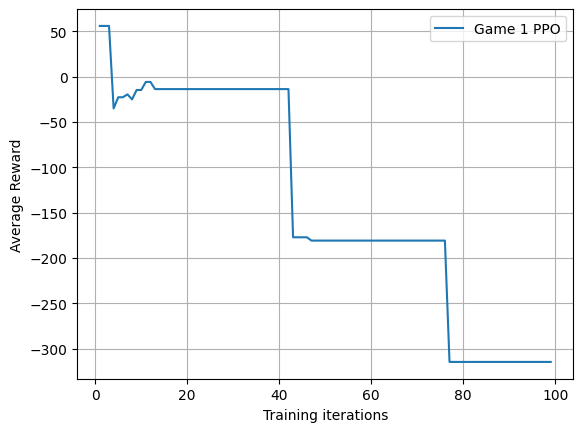

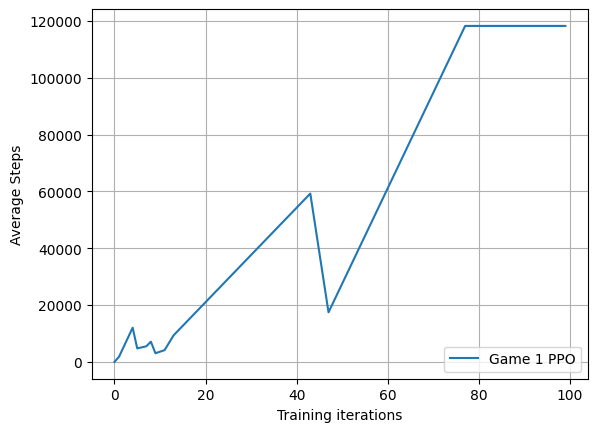

In [28]:
print(avg_rewards)
steps_taken = [0,1810,12046,4765,5500,7118,3058,(8223+54)/2,9386,(118465+60)/2,17451,118263,118263]
steps_taken_zero=num_iterations.copy()

for x in steps_taken_zero:
    steps_taken_zero[x]=0
#Write down episode number [] and steps in that episode (=)
steps_taken_zero[1]=1810
steps_taken_zero[4]=12046
steps_taken_zero[5]=4765
steps_taken_zero[7]=5500
steps_taken_zero[8]=7118
steps_taken_zero[9]=3058
steps_taken_zero[11]=(8223+54)/2
steps_taken_zero[13]=9386
steps_taken_zero[43]=(118465+60)/2
steps_taken_zero[47]=17451
steps_taken_zero[77]=118263
steps_taken_zero[99]=118263
print(steps_taken_zero)

scat_iter = []
scat_value = []
for x in num_iterations:
    if x==0:
        scat_iter.append(x)
    if steps_taken_zero[x]!=0:
        scat_iter.append(x)
#         scat_value.append(avg_rewards[x])
print(scat_iter)
# print(scat_value)


# steps_taken_avg = []
# for x in range(1,len(steps_taken)+1):
#     steps_taken_avg_temp = steps_taken[x]/x
#     steps_taken_avg.append(steps_taken_avg_temp)


import matplotlib.pyplot as plt
plt.plot(num_iterations, avg_rewards, label="Game 1 PPO")   
plt.xlabel("Training iterations")
plt.ylabel("Average Reward")
plt.legend(loc=1)
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt
plt.plot(scat_iter, steps_taken, label="Game 1 PPO")    
plt.xlabel("Training iterations")
plt.ylabel("Average Steps")
plt.legend(loc=4)
plt.grid(True)
plt.show()